# 导入

In [170]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
import plotly.graph_objects as go
import plotly.express as px

import networkx as nx
from collections import Counter

# 社会网络分析

# 将主题结果添加到数据中

In [183]:
# 将主题编号添加到DataFrame中
df['topic'] = topics

# 查看数据
print(df.head())

# 解释：

# 将每条文本对应的主题编号添加到df的topic列中，便于后续分析。

                                           complaint  topic
0  CPU 温度 极高 玩游戏 cpu 温度 轻松 以上 cpu 频率 降低 高能 达到 严重 ...     -1
1             产品质量 无故 花屏 重启 乱码 无法 开机 苹果 官方 直营店 不能 维修     -1
2  产品 达到 国家 产品 标准 条件 发生 爆裂 事故现场 造成 严重 破坏 墙面 大面积 脱...     -1
3                               非常 便宜 大量 霉烂 松子 黄曲 毒素     -1
4  今年 七月 淘宝 订购 品牌 行车 记录仪 安装 第一天 倒车 视屏 闪屏 情况 通知 卖方...     -1


# 提取主题关键词

In [185]:
# 获取每个主题的前N个关键词
n_keywords = 70
topic_keywords = {}

for topic_num in topic_info.Topic.unique():
    if topic_num == -1:
        # -1表示未分配到任何主题的文档，跳过
        continue
    words_probs = topic_model.get_topic(topic_num)
    words = [word for word, _ in words_probs[:n_keywords]]
    topic_keywords[topic_num] = words

# 打印部分主题的关键词
for topic_num, keywords in list(topic_keywords.items())[:20]:
    print(f"主题 {topic_num}: {keywords}")


# 解释：

# 遍历每个主题编号，使用get_topic方法获取主题对应的关键词及其权重。
# 提取每个主题的前n_keywords个关键词，存储在字典topic_keywords中。
# 打印前5个主题的关键词列表进行预览。

主题 0: ['手机', '自动关机', '苹果', '电量', '电池', '开机', '小米', '关机', '情况', '售后']
主题 1: ['电池', '自动关机', '电量', '开机', '关机', '鼓包', '充电', '情况', '充电器', '才能']
主题 2: ['苹果', '电脑', '黑线', '维修', '屏幕', '苹果公司', '笔记本电脑', '部件', '自费', '购买']
主题 3: ['电动车', '轮胎', '小牛', '车辆', '行驶', '骑行', '车子', '定位', '刹车', '公里']
主题 4: ['洗衣机', '净水器', '漏水', '售后', '维修', '上门', '机器', '滤芯', '安装', '客服']
主题 5: ['电脑', '联想', '笔记本', '戴尔', '维修', '硬盘', '客服', '售后', '主板', '京东']
主题 6: ['电视', '电视机', '海信', '主板', '上门', '小米', '维修', '乐视', '售后', '人员']
主题 7: ['手环', '小米', '屏幕', '变暗', '竖线', '固件', '笔记本', '亮度', '升级', 'air13']
主题 8: ['屏幕', '变暗', '亮度', '看不清', '屏幕显示', '看清', '手环', '无法', '显示', '看不见']
主题 9: ['耳机', '耳朵', '佩戴', '发炎', '蓝牙', '客服', '索尼', '产品', '售后', '降噪']
主题 10: ['自动关机', '关机', '重启', '严重', '近端', '影响', '异响', '无故', '无限', '内胆']
主题 11: ['鞋子', '鞋底', '开胶', '质量', '商家', '李宁', '客服', '商品', '换货', '运动鞋']
主题 12: ['爆炸', '玻璃', '安全隐患', '微波炉', '燃气灶', '火灾', '起火', '面板', '造成', '油烟机']
主题 13: ['空调', '制冷', '格力', '安装', '格力空调', '售后', '上门', '维修', '漏水', '内机']
主题 14: ['商家', '手链', '门店',

# 构建关键词共线矩阵 + 导出共线矩阵CSV

In [188]:
# 构建关键词列表和索引映射
all_keywords = set()
for keywords in topic_keywords.values():
    all_keywords.update(keywords)
all_keywords = list(all_keywords)
keyword_to_idx = {keyword: idx for idx, keyword in enumerate(all_keywords)}

# 初始化共现矩阵
cooccurrence_matrix = np.zeros((len(all_keywords), len(all_keywords)), dtype=int)

# 计算共现次数
for keywords in topic_keywords.values():
    for i in range(len(keywords)):
        for j in range(i+1, len(keywords)):
            idx_i = keyword_to_idx[keywords[i]]
            idx_j = keyword_to_idx[keywords[j]]
            cooccurrence_matrix[idx_i][idx_j] += 1
            cooccurrence_matrix[idx_j][idx_i] += 1  # 对称矩阵

# 将共现矩阵转换为DataFrame
cooccurrence_df = pd.DataFrame(cooccurrence_matrix, index=all_keywords, columns=all_keywords)
print(cooccurrence_df.head())

#导出共线矩阵为CSV 
output_file_path = 'E:\\任务\\Bertopic\\BERTopic+社会网络分析\\data\\共现矩阵.csv'  # 修改为您的文件路径
cooccurrence_df.to_csv(output_file_path, encoding='utf-8-sig')  # 使用utf-8-sig编码以确保中文字符正确显示

# 导出节点和边数据为CSV格式
nodes_output_path = 'E:\\任务\\Bertopic\\BERTopic+社会网络分析\\data\\节点数据.csv'
edges_output_path = 'E:\\任务\\Bertopic\\BERTopic+社会网络分析\\data\\边数据.csv'

# 生成节点数据
nodes_df = pd.DataFrame(all_keywords, columns=['label'])
nodes_df.to_csv(nodes_output_path, index=False, encoding='utf-8-sig')

# 生成边数据（只保留共现次数大于0的边）
edges_list = []
for i in range(len(all_keywords)):
    for j in range(i + 1, len(all_keywords)):
        if cooccurrence_matrix[i][j] > 0:
            edges_list.append({
                'source': all_keywords[i],
                'target': all_keywords[j],
                'weight': cooccurrence_matrix[i][j]
            })

edges_df = pd.DataFrame(edges_list)
edges_df.to_csv(edges_output_path, index=False, encoding='utf-8-sig')

# 解释：

# 创建一个无向图G，节点为关键词。
# 通过遍历共现矩阵，添加边到图中。只添加共现次数大于等于阈值的关键词对，减少噪音。
# threshold可以根据实际情况调整，默认设为1，即至少共现一次。
# 打印网络中的节点和边数量，了解网络规模。

    内胆  轮胎  间歇  造成  戴尔  导光板  飞机  近端  亮度  处理  ...  屏幕显示  返航  售后  安装  表带  mm  \
内胆   0   0   0   0   0    0   0   1   0   0  ...     0   0   0   0   0   0   
轮胎   0   0   0   0   0    0   0   0   0   0  ...     0   0   0   0   0   0   
间歇   0   0   0   0   0    0   0   0   0   0  ...     0   0   0   0   0   0   
造成   0   0   0   0   0    0   0   0   0   0  ...     0   0   0   0   0   0   
戴尔   0   0   0   0   0    0   0   0   0   0  ...     0   0   1   0   0   0   

    制冷  起火  安全隐患  行驶  
内胆   0   0     0   0  
轮胎   0   0     0   1  
间歇   0   0     0   0  
造成   0   1     1   0  
戴尔   0   0     0   0  

[5 rows x 150 columns]


# 构建关键词共线网络

In [189]:
# 创建无向图
G = nx.Graph()

# 添加节点（关键词）
for keyword in all_keywords:
    G.add_node(keyword)

# 添加边（共现次数大于0的关键词对）
threshold = 1  # 设置共现次数阈值，过滤掉低频共现
for i in range(len(all_keywords)):
    for j in range(i+1, len(all_keywords)):
        weight = cooccurrence_matrix[i][j]
        if weight >= threshold:
            G.add_edge(all_keywords[i], all_keywords[j], weight=weight)

print(f"网络中节点数量：{G.number_of_nodes()}")
print(f"网络中边数量：{G.number_of_edges()}")


# 解释：

# 创建一个无向图G，节点为关键词。
# 通过遍历共现矩阵，添加边到图中。只添加共现次数大于等于阈值的关键词对，减少噪音。
# threshold可以根据实际情况调整，默认设为1，即至少共现一次。
# 打印网络中的节点和边数量，了解网络规模。

网络中节点数量：150
网络中边数量：848


# 网络可视化

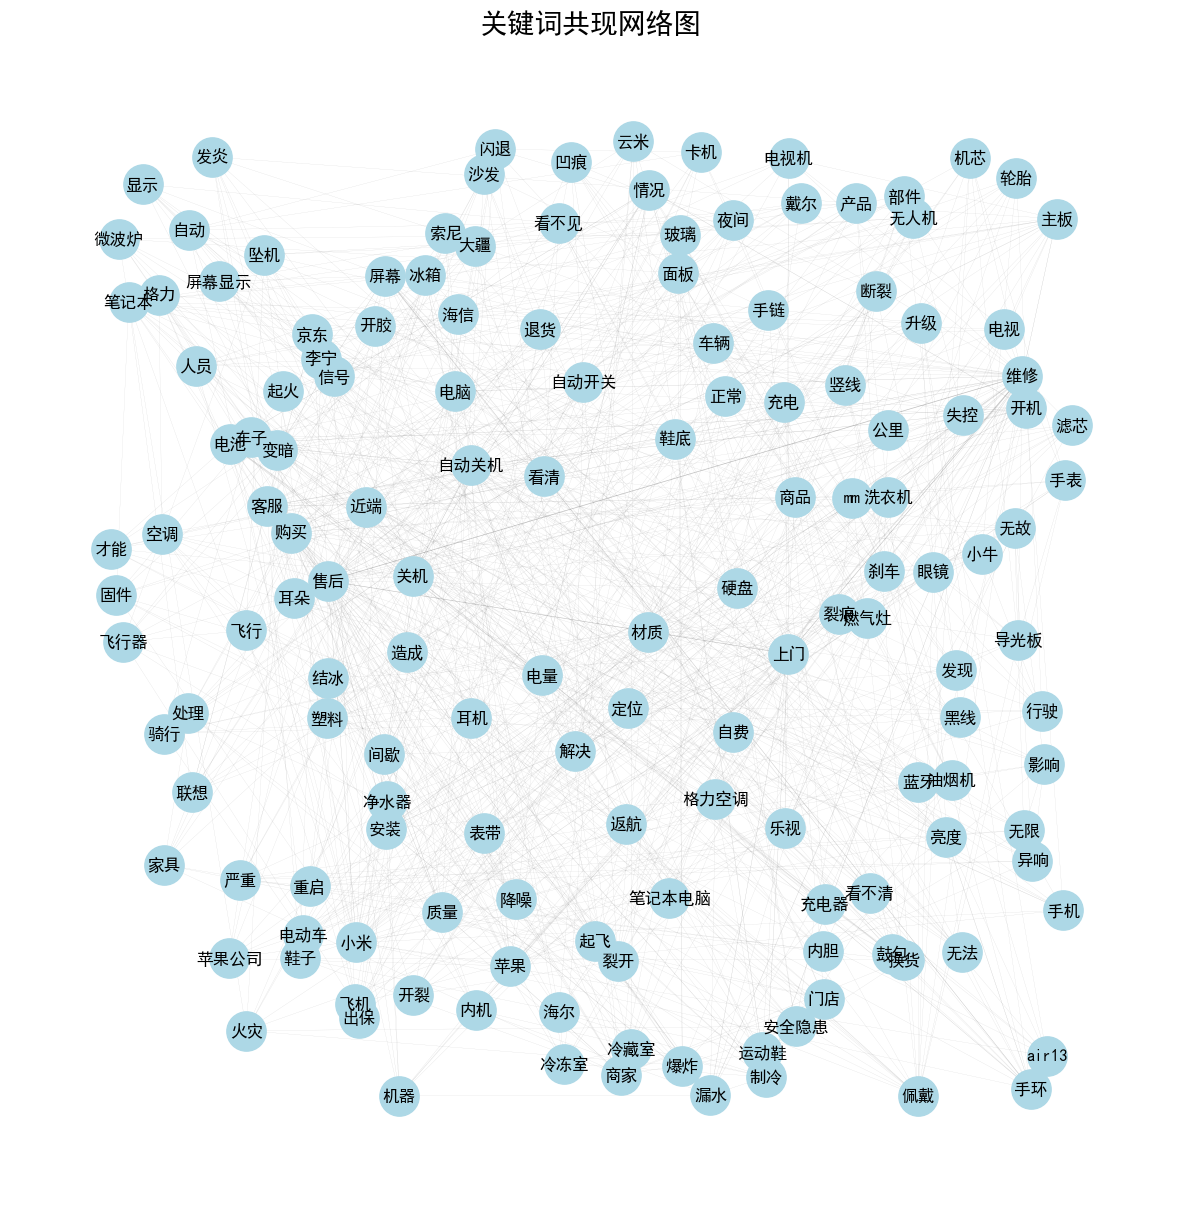

In [201]:
# 设置绘图参数
plt.figure(figsize=(15, 15))

# 计算节点位置
pos = nx.spring_layout(G, k=0.8, iterations=1)

# 绘制节点
nx.draw_networkx_nodes(G, pos, node_size=800, node_color='lightblue')

# 根据边的权重设置边的透明度和宽度
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5, width=[w * 0.1 for w in weights])

# 绘制节点标签
nx.draw_networkx_labels(G, pos, font_size=12, font_family='SimHei')

# 显示图形
plt.title("关键词共现网络图", fontsize=20)
plt.axis('off')
plt.show()

# 解释：

# 使用spring_layout计算节点的位置，k值和iterations次数可以调整布局效果。
# 绘制节点，设置大小和颜色。
# 根据边的权重（共现次数），设置边的透明度和宽度，权重大的边更突出。
# 绘制节点标签，设置字体大小和字体（SimHei用于显示中文）。
# 隐藏坐标轴，显示标题，展示网络图。

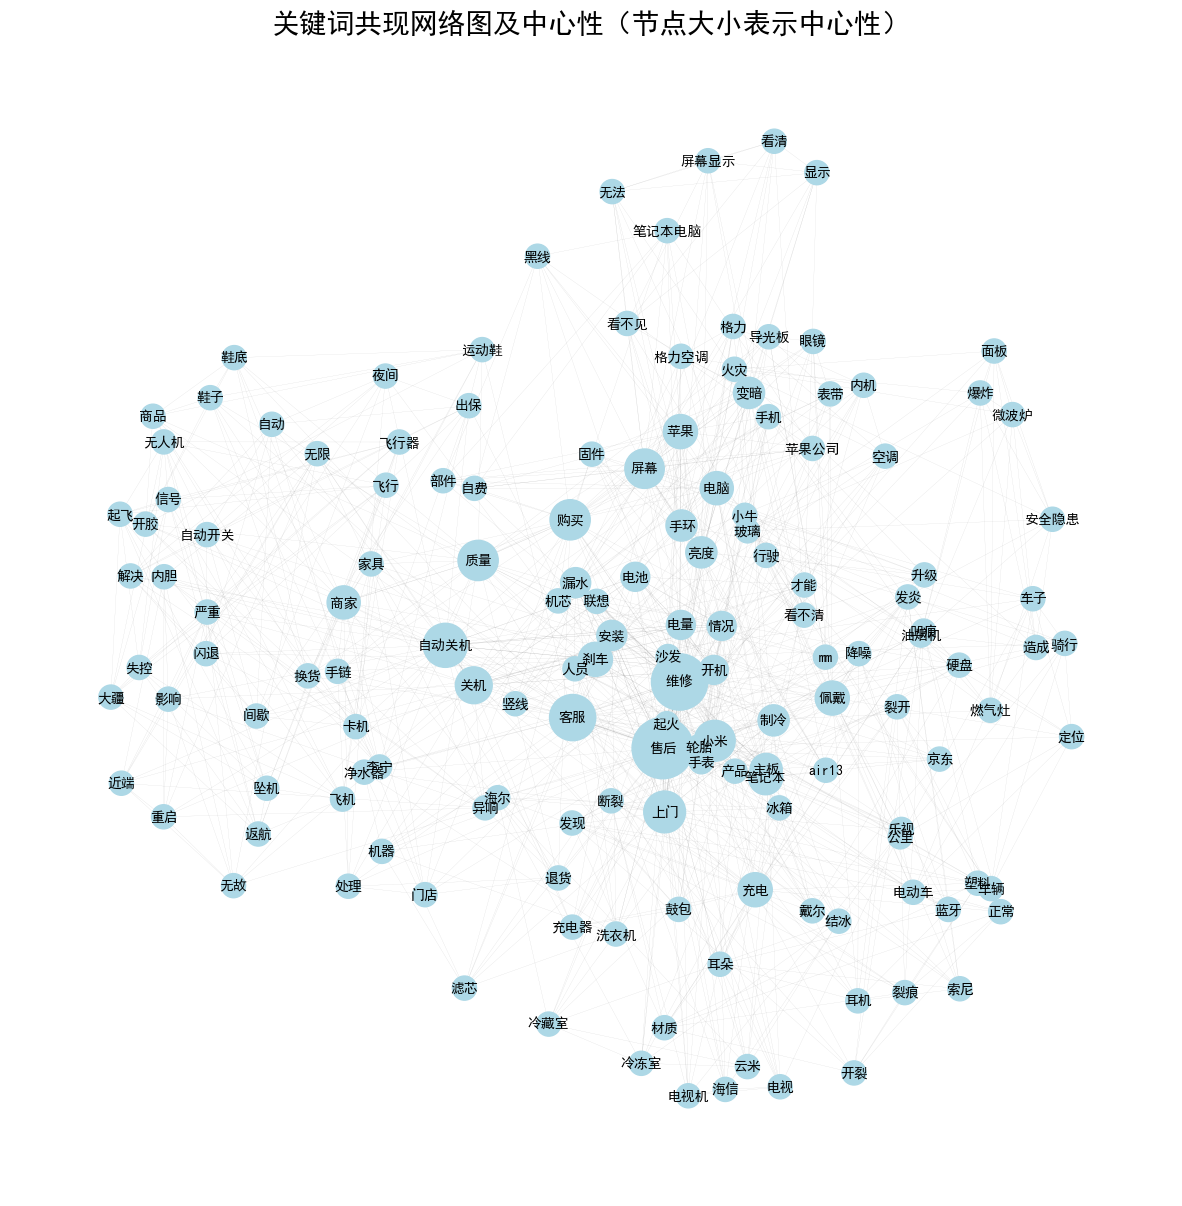

In [203]:
import matplotlib.pyplot as plt
import networkx as nx

# 计算度中心性
degree_centrality = nx.degree_centrality(G)

# 将中心性值转换为节点大小
node_sizes = [v * 5000 for v in degree_centrality.values()]  # 乘以5000以调整可视化效果

# 设置绘图参数
plt.figure(figsize=(15, 15))

# 计算节点位置
pos = nx.spring_layout(G, k=0.8, iterations=50)

# 绘制节点，节点大小根据中心性
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightblue')

# 根据边的权重设置边的透明度和宽度
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5, width=[w * 0.1 for w in weights])

# 绘制节点标签
nx.draw_networkx_labels(G, pos, font_size=10, font_family='SimHei')

# 显示图形
plt.title("关键词共现网络图及中心性（节点大小表示中心性）", fontsize=20)
plt.axis('off')
plt.show()


# 网络分析

In [206]:
# 计算度中心性
degree_centrality = nx.degree_centrality(G)
degree_centrality_sorted = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
print("度中心性排名前10的关键词：")
for keyword, centrality in degree_centrality_sorted[:10]:
    print(f"{keyword}: {centrality:.4f}")

# 计算介数中心性
betweenness_centrality = nx.betweenness_centrality(G)
betweenness_centrality_sorted = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
print("\n介数中心性排名前10的关键词：")
for keyword, centrality in betweenness_centrality_sorted[:10]:
    print(f"{keyword}: {centrality:.4f}")

# 社区检测
from networkx.algorithms import community

# 使用Girvan-Newman算法进行社区检测
communities_generator = community.girvan_newman(G)
top_level_communities = next(communities_generator)
communities = [list(c) for c in top_level_communities]
print(f"\n检测到的社区数量：{len(communities)}")
for i, community_keywords in enumerate(communities):
    print(f"社区 {i+1}: {community_keywords}")

# 解释：

# 度中心性：反映节点与其他节点的连接程度。度中心性高的关键词在网络中具有更多的直接连接，可能是投诉内容中的高频词。
# 介数中心性：反映节点在网络中作为桥梁的作用。介数中心性高的关键词可能连接着不同的主题，是重要的枢纽词。
# 社区检测：使用Girvan-Newman算法进行社区划分，识别网络中的聚集结构，每个社区可能对应一个主题或子主题。

度中心性排名前10的关键词：
售后: 0.3893
维修: 0.3289
客服: 0.2215
自动关机: 0.2013
上门: 0.1812
小米: 0.1745
质量: 0.1678
购买: 0.1678
屏幕: 0.1611
关机: 0.1409

介数中心性排名前10的关键词：
售后: 0.2993
自动关机: 0.2349
刹车: 0.0980
充电: 0.0980
小米: 0.0918
维修: 0.0889
关机: 0.0537
屏幕: 0.0514
客服: 0.0513
苹果: 0.0417

检测到的社区数量：4
社区 1: ['卡机', '公里', '影响', '开裂', '车辆', '材质', '内胆', '充电', '轮胎', '闪退', '电量', '间歇', '才能', '裂痕', '无故', '开机', '发现', '近端', '手机', '骑行', '塑料', '凹痕', '定位', '夜间', '自动关机', '情况', '小牛', '严重', '出保', '重启', '裂开', '解决', '电池', '鼓包', '车子', '自动开关', '自动', '关机', '正常', '无限', '刹车', '充电器', '电动车', '行驶', '异响', '断裂']
社区 2: ['油烟机', '面板', '玻璃', '爆炸', '火灾', '微波炉', '起火', '安全隐患', '燃气灶', '造成']
社区 3: ['戴尔', '导光板', '亮度', '处理', '黑线', '硬盘', '运动鞋', '质量', '显示', '空调', '自费', '佩戴', '看不见', '联想', '苹果', '购买', '格力空调', '发炎', '降噪', '苹果公司', '笔记本', '固件', '看清', '冷冻室', '内机', '鞋子', '海信', '笔记本电脑', '退货', '乐视', '机器', '漏水', '机芯', '商品', '电视', '手链', '蓝牙', '上门', '滤芯', '冰箱', '手环', '京东', '电视机', '耳朵', '洗衣机', '耳机', '结冰', '维修', '格力', '看不清', '客服', '鞋底', '屏幕', '小米', '商家', '冷藏室', '变暗', '无法', 

# 将网络分析结果与主题结合

In [204]:
# 将中心性指标添加到关键词数据中
keyword_metrics = pd.DataFrame({
    'keyword': list(degree_centrality.keys()),
    'degree_centrality': list(degree_centrality.values()),
    'betweenness_centrality': [betweenness_centrality[key] for key in degree_centrality.keys()]
})

# 打印关键词的中心性指标
print("\n关键词中心性指标：")
print(keyword_metrics.sort_values(by='degree_centrality', ascending=False).head(10))

# 解释：

# 将计算得到的中心性指标整理成一个DataFrame，便于查看和分析。
# 可以根据中心性指标排序，找到在网络中最重要的关键词。
# 这些关键词可能是需要重点关注的问题，或者是具有代表性的主题词。


关键词中心性指标：
    keyword  degree_centrality  betweenness_centrality
142      售后           0.389262                0.299327
83       维修           0.328859                0.088890
87       客服           0.221477                0.051333
132    自动关机           0.201342                0.234914
72       上门           0.181208                0.009133
91       小米           0.174497                0.091786
32       购买           0.167785                0.029355
15       质量           0.167785                0.028710
90       屏幕           0.161074                0.051371
96       关机           0.140940                0.053706


# 可视化带有中心性指标的网络

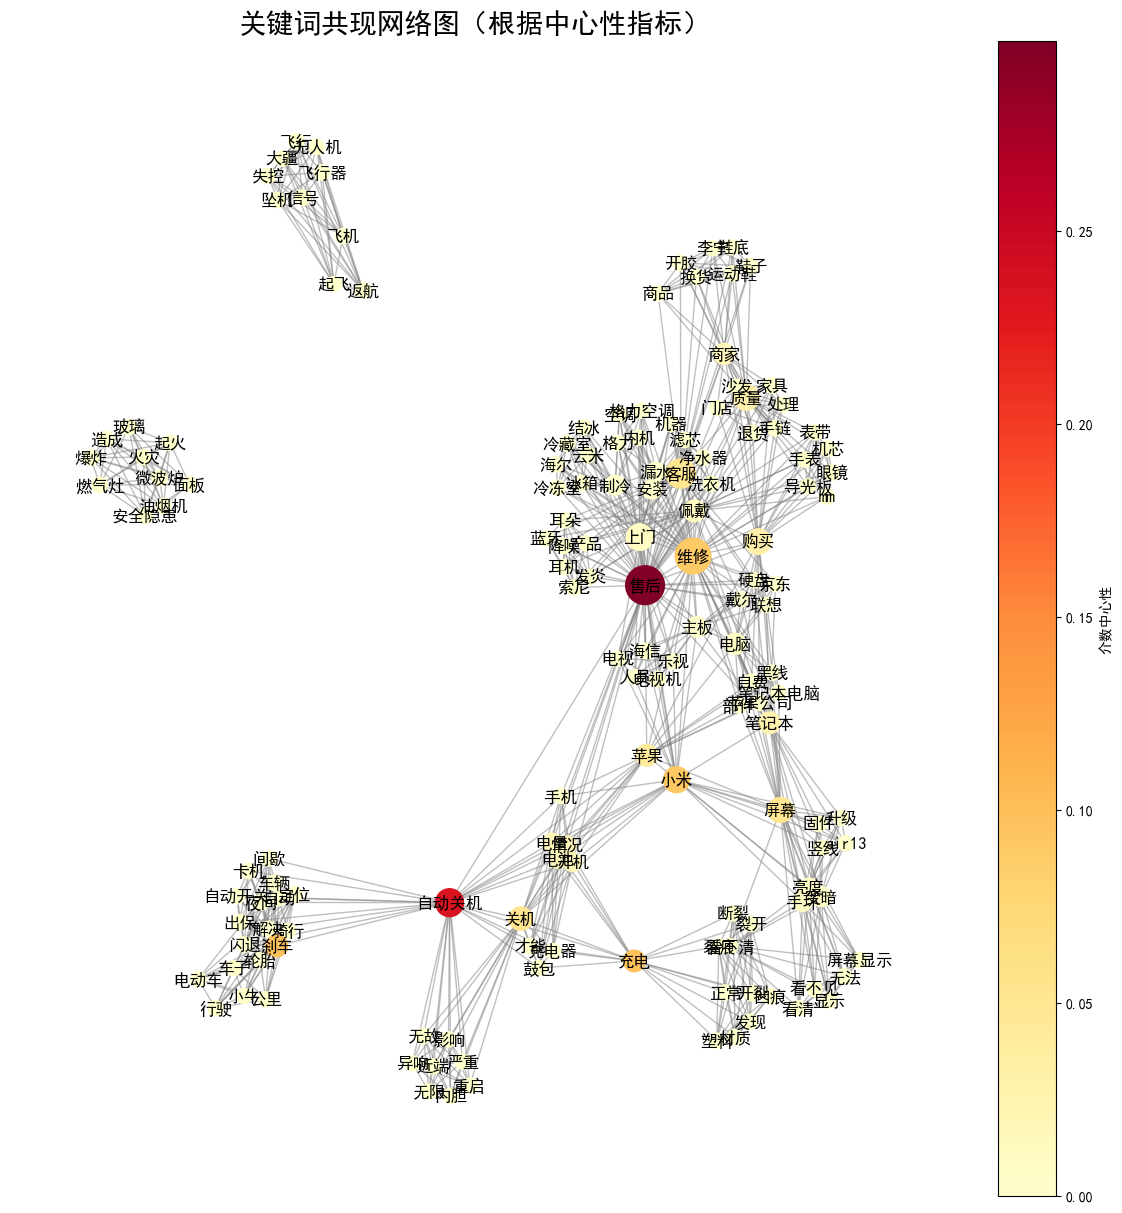

In [205]:
# 根据度中心性设置节点大小
node_sizes = [degree_centrality[node]*2000 for node in G.nodes()]

# 根据介数中心性设置节点颜色
node_colors = [betweenness_centrality[node] for node in G.nodes()]

# 绘制网络图
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, k=0.3, iterations=50)
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.YlOrRd)
edges = nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=12, font_family='SimHei')

plt.title("关键词共现网络图（根据中心性指标）", fontsize=20)
plt.colorbar(nodes, label='介数中心性')
plt.axis('off')
plt.show()

# 解释：

# 使用度中心性设置节点大小，度中心性高的节点更大。
# 使用介数中心性设置节点颜色，介数中心性高的节点颜色更深。
# 通过这种方式，可以更加直观地看到网络中重要的关键词。